In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
from matplotlib import pyplot as plt

from timeit import default_timer as timer
from datetime import timedelta

import math
import random

from qutip import Bloch, Bloch3d, basis
from qutip.qip.operations import rz

from spectator_env_v2 import SpectatorEnvContinuousV2

from qutip.operators import sigmax, sigmay, sigmaz
from qutip.qip.operations import snot
from qutip import basis, expect

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def plot(axs, frame_idx, elapsed_time, baseline_fidelity=None,
         corrected_fidelity=None,  context_theta_history=None,
         correction_theta_history=None, context_outcome_hist=None):
    if correction_theta_history:
        axs[0].set_title('Correction phase space (per batch update)')
        for k, v in correction_theta_history.items():
            alphas = np.linspace(0.1, 1, len(v))
            rgba_colors = np.zeros((len(v),4))
            rgba_colors[:, 1] = 1 - k
            rgba_colors[:, 2] = k
            rgba_colors[:, 3] = alphas
            axs[0].scatter([x[1] for x in v], [x[0] for x in v], c=rgba_colors,
                           label=k)

        axs[0].legend()

    if context_theta_history:
        alphas = np.linspace(0.1, 1, len(context_theta_history))
        rgba_colors = np.zeros((len(context_theta_history),4))
        rgba_colors[:, 2] = 1.0
        rgba_colors[:, 3] = alphas

        axs[1].set_title('Context phase space (per batch update)')
        axs[1].scatter([x[1] for x in context_theta_history], [x[0] for x in context_theta_history], c=rgba_colors)

    if baseline_fidelity and corrected_fidelity:
        axs[2].set_title('Fidelity (per episode)')
        axs[2].plot(corrected_fidelity, 'g', label='corrected')
        axs[2].plot(baseline_fidelity, 'r', label='uncorrected')
        axs[2].legend()

    if context_outcome_hist:
        axs[3].set_title('Distribution of contextual outcomes')
        axs[3].hist(context_outcome_hist)

In [4]:
# (action, reward) distribution for a given "spectator measurement outcome" state
class Context:
    def __init__(self, gamma, eta):
        # discount factor
        self.gamma = gamma
        self.eta = eta

        self.batch_correction_feedback = ([], [], [])
        self.correction_theta = [0, 0, 0]

    def reset(self):
        self.batch_correction_feedback = ([], [], [])

    def discount(self):
        pass

    def update_gamma(self, gamma):
        self.gamma = gamma

    def update_batch_feedback(self, correction_feedback, idx):
        self.batch_correction_feedback[idx].append(correction_feedback)

    def get_and_combine_optimal_theta(self):
        if len(self.batch_correction_feedback[0]) == 0:
            return self.correction_theta

        # feedback is given per theta
        for idx, f in enumerate(self.batch_correction_feedback):
            lo = [r[0] for r in f]
            mid = [r[1] for r in f]
            hi = [r[2] for r in f]

            mu_plus = np.mean(hi)
            mu_minus = np.mean(lo)

            grad = mu_plus - mu_minus

            self.correction_theta[idx] += self.eta * grad

        self.reset()

        return self.correction_theta

    def get_optimal_theta(self):
        return self.correction_theta

In [5]:
# contextual analytic geometric descent
class Analytic2D:
    def __init__(self, env, initial_gamma=0.99, context_eta=np.pi/64,
                 correction_eta=np.pi/64):
        # two contexts -> pos vs neg rotation with respect to a chosen
        # rotational basis
        self.contexts = [Context(initial_gamma, correction_eta),
                         Context(initial_gamma, correction_eta)]

        self.rewards = []
        self.fidelity = []
        self.control_fidelity = []

        self.num_context_spectators = env.num_context_spectators
        self.num_reward_spectators = env.num_reward_spectators

        # step size
        self.eta = context_eta

        self.batch_context_feedback = ([], [], [])
        self.context_theta = [0, 0, 0]

    def get_actions(self, observations):
        # Our context is an array of binary spectator qubit measurements.
        # Hence, we could convert this binary array to an integer and index
        # 2^(spectator qubits) contexts.
        # For now, we only have two contexts (+ vs -), and so we consider
        # spectators to be indistinguishable noise polling devices.
        # In the future, we may consider noise gradients and so we do indeed
        # need to track the specific arrangement.

        actions = []
        for observation in observations:
            context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
            context = self.contexts[context_idx]

            # (theta vec)

            if len(self.batch_context_feedback[0]) != 0:
                for idx, f in enumerate(self.batch_context_feedback):
                    lo = [r[0] for r in f]
                    mid = [r[1] for r in f]
                    hi = [r[2] for r in f]

                    mu = np.mean(mid)
                    var_grad = np.mean([2 * (m - mu) * (h - l)
                                        for l, m, h in zip(lo, mid, hi)])

                    self.context_theta[idx] += self.eta * var_grad
                self.batch_context_feedback = ([], [], [])

            actions.append((context.get_and_combine_optimal_theta(), self.context_theta))
        return actions

    def update(self, context_feedback, correction_feedback, observations):
        for context in self.contexts:
            context.reset()

        # feedback is given per theta
        for idx in range(len(self.context_theta)):
            for _context_feedback, _correction_feedback, observation in zip(
                    context_feedback[idx], correction_feedback[idx], observations):
                context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
                context = self.contexts[context_idx]
                context.update_batch_feedback(_correction_feedback, idx)

                self.batch_context_feedback[idx].append(_context_feedback)

    def _update_gammas(self, gamma):
        for context in self.contexts:
            context.update_gamma(gamma)

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_fidelity(self, fidelity):
        self.fidelity.append(fidelity)

    def save_control_fidelity(self, fidelity):
        self.control_fidelity.append(fidelity)

In [6]:
M = 100
BATCH_SIZE = 10

MU = 0
SIGMA = np.pi / 4

# add some random harmonics
# time_dependent_fn = np.vectorize(lambda x: (2/5) * np.pi * np.sin(2 * np.pi * x / M))
error_samples = np.random.normal(MU, SIGMA, M) # + time_dependent_fn(np.arange(M))
# error_samples = np.random.choice([-np.pi/4, np.pi / 4], M)

In [7]:
# describes MDP
# - states are given in terms of a #context_spectators bit measurement outcomes
# - continuous action space is given by ([-pi, pi], smoothing parameter, contextual_measurement_bias) i.e. \U(1) \times U(1) \times U(1)
env = SpectatorEnvContinuousV2(error_samples, batch_size=BATCH_SIZE, num_context_spectators=64, num_reward_spectators=64, context_sensitivity=1.0, reward_sensitivity=1.0)

In [8]:
def extract_theta_phi(single_qubit_gate):
    # apply gate to |+>
    ket = single_qubit_gate * snot() * basis(2, 0)

    alpha = ket.full()[0][0]
    beta = ket.full()[1][0]
    # rewrite in x-basis
    ket_raw = [(alpha + beta) / 2, (alpha - beta) / 2]
    ket_raw = ket_raw / np.linalg.norm(ket_raw)

    theta = 0
    phi = 0

    if ket_raw[0] * ket_raw[0].conj() < 1e-6:
        theta = np.pi
        phi = 0
    elif ket_raw[1] * ket_raw[1].conj() < 1e-6:
        theta = 0
        phi = 0
    else:
        theta = 2 * np.arccos(np.sqrt(ket_raw[0] * ket_raw[0].conj()))
        phi = np.angle(ket_raw[0].conj() * ket_raw[1] / (np.sqrt(ket_raw[0] * ket_raw[0].conj()) * np.sqrt(ket_raw[1] * ket_raw[1].conj())))

    return theta, phi


In [9]:
g1 = 1j * np.pi / 4 * sigmay()
g2 = 1j * np.pi / 8 * sigmax()
g3 = 1j * np.pi / 3 * sigmay()

gate = (g3.expm() * g2.expm() * g1.expm()).dag()
print(extract_theta_phi(gate))

((2.229854362621306+0j), -0.8860771237926144)


In [10]:
prepared_basis = [snot() * basis(2,0), snot() * sigmax() * basis(2,0)]
trans = [rz(sample) *  prepared_basis[0] for sample in error_samples]

thetas = np.linspace(-np.pi, np.pi, 33)
phis = np.linspace(-np.pi, np.pi, 33)
loss = np.zeros((len(thetas), len(phis)))

min_phi = 0.
min_theta = 0.
min_loss = 1.

max_phi = 0.
max_theta = 0.
max_loss = 0.
for i, theta in enumerate(thetas):
    for j, phi in enumerate(phis):
        meas = np.cos(theta / 2) * prepared_basis[0] + np.exp(1j * phi) * np.sin(theta / 2) * prepared_basis[1]
        meas = meas.unit()

        objective = np.var([t.overlap(meas) * meas.overlap(t) for t in trans])
        if (np.abs(objective) < min_loss):
            min_loss = objective
            min_phi = phi
            min_theta = theta
        if (np.abs(objective) > max_loss):
            max_loss = objective
            max_phi = phi
            max_theta = theta
        loss[i][j] = np.abs(objective)

In [11]:
print(max_phi, max_theta)

1.5707963267948966 -1.5707963267948966


[[33]] [[33]]


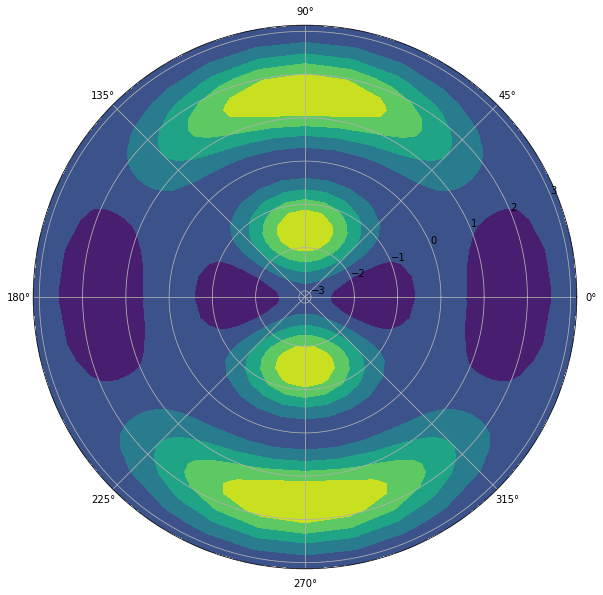

In [12]:
fig, ax = plt.subplots(figsize=(20,10), subplot_kw=dict(projection='polar'))
r, theta = np.meshgrid(len(thetas), len(phis))
print(r, theta)
ax.contourf(phis, thetas, loss)

plt.show()

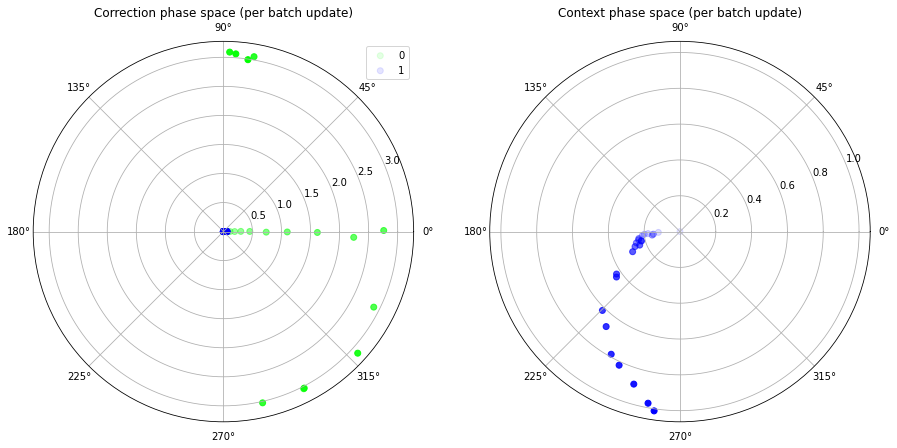

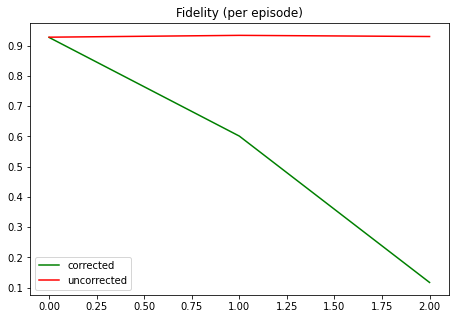

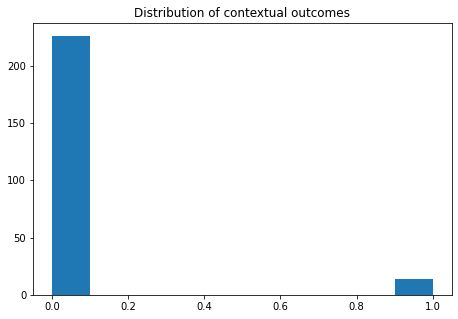

In [ ]:
start = timer()

md = Analytic2D(env, initial_gamma=1.0, context_eta=np.pi / 8, correction_eta=np.pi / 16)

episode_fidelity = []
control_fidelity = []

MAX_FRAMES = 20 * M // BATCH_SIZE
UPDATE_ERROR_SAMPLES_FRAMES = M // BATCH_SIZE

# "episodes" are a reasonable way to think about learning a periodic time dependent function
# max frames = episode length * num episodes
# episodes are identical sequences of training data
observation = env.reset()

correction_2d_repr = {}
context_2d_repr = []

context_outcome_hist = []

for frame_idx in range(1, MAX_FRAMES + 1):
    actions = md.get_actions(observation)
    prev_batch = env.error_samples_batch
    prev_observation = observation
    observation, feedback, done, info = env.step(actions)
    context_feedback, correction_feedback = feedback
    observation = None if done else observation

#     print(prev_observation)
    for obs in prev_observation:
        context_outcome_hist.append(1 if np.sum(obs) > env.num_context_spectators / 2 else 0)

    # generally, in RL we would consider r(s | s', a)
    # given a state transition s' -> s due to action a
    # for now, we are only interested in r(s', a)
    md.update(context_feedback, correction_feedback, prev_observation)

    for x, y in info:
        episode_fidelity.append(x)
        control_fidelity.append(y)

    if UPDATE_ERROR_SAMPLES_FRAMES:
        new_error_samples = np.random.normal(MU, SIGMA, M)
        env.set_error_samples(new_error_samples)

    context_2d_repr.append(extract_theta_phi(env._get_correction(md.context_theta).dag()))
    for idx, c in enumerate(md.contexts):
        if idx in correction_2d_repr.keys():
            correction_2d_repr[idx].append(extract_theta_phi(env._get_correction(c.correction_theta).dag()))
        else:
            correction_2d_repr[idx] = [extract_theta_phi(env._get_correction(c.correction_theta).dag())]

    if done:
        md.save_fidelity(np.mean(episode_fidelity))
        md.save_control_fidelity(np.mean(control_fidelity))
        episode_fidelity = []
        control_fidelity = []

        observation = env.reset()

        clear_output(True)
        fig, axs = plt.subplots(1, 2, figsize=(15,10),subplot_kw=dict(polar=True))
        _, ax_fid = plt.subplots(1, 1, figsize=(7.5,5))
        _, ax_hist = plt.subplots(1, 1, figsize=(7.5,5))
        plot(np.concatenate((axs, [ax_fid, ax_hist])), frame_idx,
            timedelta(seconds=int(timer()-start)),
            baseline_fidelity=md.control_fidelity,corrected_fidelity=md.fidelity,
            context_theta_history=context_2d_repr, correction_theta_history=correction_2d_repr, context_outcome_hist=context_outcome_hist)
        plt.show()

env.close()

